# Grokking

In [ ]:
import train
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Setup 
# See train.py for more options
args = {
    'mod': '97',
    "math_op": "/",
    "epochs": "1",
    "n_layer": "2",
    "n_head": "4",
    "n_embd": "128",
    "block_size": "32",  # [x, y, =] or [x, y, z]
    "dropout": "0.0",
    "bias": "True",
    "learning_rate": "1e-3",
    "weight_decay": "1",
    "batch_size": "512",
    'exp_name': "grok",
    "eval_every": "1000",
    "num_steps": "1_000_000",
}
config = train.parse_args(train.build_arg_input(**args))
print("Config loaded. Using config")

train_loader, val_loader, test_loader = train.load_dataset(config)
print("Data loaded")
# print(json.dumps(vars(config), indent=4))


# Create the transformer
gpt, optimizer = train.gen_gpt(config)
print("GPT built")
# Train loop
print("Train started")
train_losses, train_acc, val_losses, val_acc = train.train_model(
    gpt, train_loader, val_loader, config, optimizer
)
print("Train done")

# Testing
train.test_model(gpt, test_loader, config)

# Save trained model,configs and losses
with open(config.exp_name + "_config.json", "w") as f:
    json.dump(vars(config), f, indent=4)

torch.save(gpt.state_dict(), config.exp_name + ".pth")

with open(config.exp_name + "_losses.json", "w") as f:
    json.dump({"train_losses": train_losses, "val_losses": val_losses}, f)

print(len(train_losses))
print(len(val_losses))
# df = pd.DataFrame({"train_losses": train_losses, "val_losses": val_losses})
# df.to_csv(f"{config.exp_name}_losses.csv", index=False)
# df.to_parquet(f"{config.exp_name}_losses.csv", index=False)

## Visualize Grokking

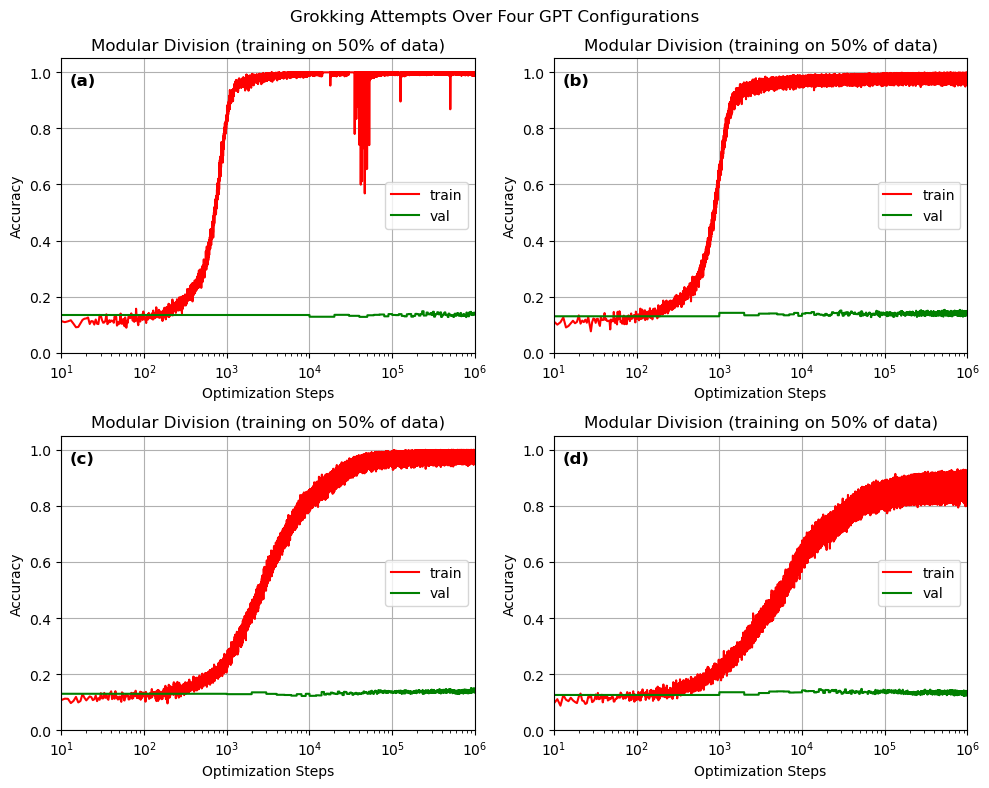

In [13]:
# Accuracy
grok_train_acc = list(map(
    lambda f: np.load(f),
    [
        "grokking/runs/2/grok_train_acc.npy",
        "grokking/runs/3/grok_train_acc_opt1.npy",
        "grokking/runs/3/grok_train_acc_opt2.npy",
        "grokking/runs/3/grok_train_acc_opt3.npy",  
    ]
))

grok_val_acc = list(map(
    lambda f: np.load(f),
    [
        "grokking/runs/2/grok_val_acc.npy",
        "grokking/runs/3/grok_val_acc_opt1.npy",
        "grokking/runs/3/grok_val_acc_opt2.npy",
        "grokking/runs/3/grok_val_acc_opt3.npy",
    ]
))
grok_val_acc[0] = np.repeat(np.mean(grok_val_acc[0], axis=1), 10)

labels = ['(a)', '(b)', '(c)', '(d)']
def plot_results(ax, train, val, label):
    steps = np.arange(1e6)
    ax.plot(steps, train, color='red', label='train')
    ax.plot(steps, np.repeat(val, 1000), color='green', label='val')

    # Decorations
    ax.set_xscale("log")
    ax.set_xlabel("Optimization Steps")
    ax.set_ylabel("Accuracy")
    ax.set_title("Modular Division (training on 50% of data)")
    ax.set_ylim([0, 1.05])
    ax.set_xlim([10, 1e6])
    ax.legend()
    ax.grid(True)
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')



# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns
for train, val, ax, label in zip(grok_train_acc, grok_val_acc, axes.flat, labels):
    plot_results(ax, train, val, label)




fig.suptitle("Grokking Attempts Over Four GPT Configurations")
plt.tight_layout()
plt.show()